<a href="https://colab.research.google.com/github/dljaimes/AdvancedMethodsinDataAnalysis1Grupo_5/blob/main/Proyecto_3_Leo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 3


# Movie Genre Classification

Classify a movie genre based on its plot.

<img src="moviegenre.png"
     style="float: left; margin-right: 10px;" />




https://www.kaggle.com/c/miia4201-202019-p3-moviegenreclassification/overview

### Data

Input:
- movie plot

Output:
- Probability of the movie belonging to each genre


### Evaluation

- 50% Report with all the details of the solution, the analysis and the conclusions. The report cannot exceed 10 pages, must be send in PDF format and must be self-contained.
- 50% Performance in the Kaggle competition (The grade for each group will be proportional to the ranking it occupies in the competition. The group in the first place will obtain 5 points, for each position below, 0.25 points will be subtracted, that is: first place: 5 points, second: 4.75 points, third place: 4.50 points ... eleventh place: 2.50 points, twelfth place: 2.25 points).


### Deadline
- The project must be carried out in the groups assigned.
- Use clear and rigorous procedures.
- The delivery of the project is on August 1st, 2021, 11:59 pm, through Bloque Neón.
- No projects will be received after the delivery time or by any other means than the one established. 




### Acknowledgements

We thank Professor Fabio Gonzalez, Ph.D. and his student John Arevalo for providing this dataset.

See https://arxiv.org/abs/1702.01992

## Sample Submission

In [12]:
#!pip install -q wordcloud
#!pip install livelossplot==0.1.2

In [13]:
import pandas as pd
import os
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.model_selection import train_test_split,GridSearchCV
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

#from keras.models import Sequential
#from keras.layers import Flatten
#from keras.layers.recurrent import LSTM
#from keras.layers.core import Dense, Dropout
#from keras.layers.embeddings import Embedding
#from keras.preprocessing import sequence
#from tensorflow.keras.preprocessing.text import Tokenizer
#from tensorflow.keras.preprocessing.sequence import pad_sequences
#from livelossplot import PlotLossesKeras

#import keras
#from keras import backend as K
from sklearn.model_selection import train_test_split
import re
import nltk

from nltk.corpus import stopwords
#from livelossplot import PlotLossesKeras
import warnings
warnings.filterwarnings("ignore")

In [14]:
# Se descargan los Stopwords:
nltk.download('stopwords')
nltk.corpus.stopwords.words('english')
nltk.download('wordnet');

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sebtc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sebtc\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# 0. CARGUE DE LOS DATOS

In [15]:
dataTraining = pd.read_csv('https://github.com/albahnsen/AdvancedMethodsDataAnalysisClass/raw/master/datasets/dataTraining.zip', encoding='UTF-8', index_col=0)
dataTesting = pd.read_csv('https://github.com/albahnsen/AdvancedMethodsDataAnalysisClass/raw/master/datasets/dataTesting.zip', encoding='UTF-8', index_col=0)

In [16]:
print('Training: \n',dataTraining.head(2))
print('----'*30)
print('----'*30)
print('Testing: \n',dataTesting.head(2))

Training: 
       year                      title  \
3107  2003                       Most   
900   2008  How to Be a Serial Killer   

                                                   plot  \
3107  most is the story of a single father who takes...   
900   a serial killer decides to teach the secrets o...   

                             genres  rating  
3107             ['Short', 'Drama']     8.0  
900   ['Comedy', 'Crime', 'Horror']     5.6  
------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
Testing: 
    year                title  \
1  1999  Message in a Bottle   
4  1978     Midnight Express   

                                                plot  
1  who meets by fate ,  shall be sealed by fate ....  
4  the true story of billy hayes ,  an american c...  


# 1. ANÁLISIS VARIABLE DE SALIDA

In [17]:
dataTraining['genres'] = dataTraining['genres'].map(lambda x: eval(x)) 

le = MultiLabelBinarizer()
y_genres = le.fit_transform(dataTraining['genres'])

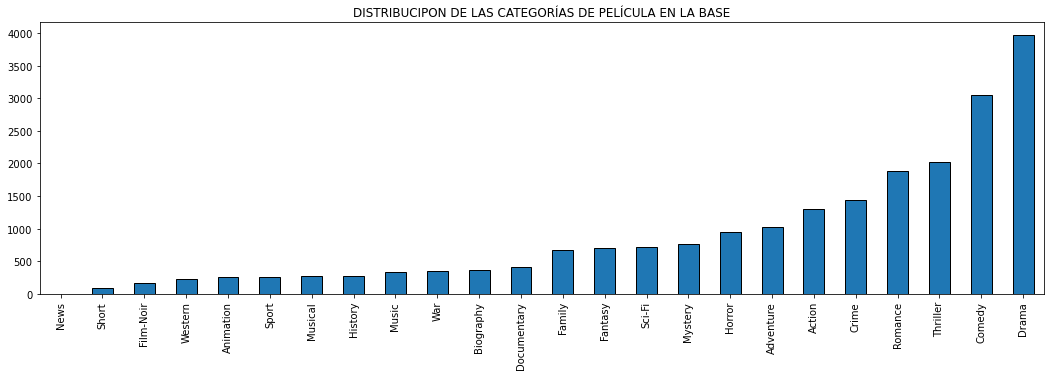

In [18]:
pd.DataFrame(y_genres, columns=le.classes_).sum().sort_values().plot(kind='bar', figsize=(18,5), grid=False, ec='black', title='DISTRIBUCIPON DE LAS CATEGORÍAS DE PELÍCULA EN LA BASE');

Se observa como las categorías de Drama, Comedy, Thriller y Romance, son las que mayor participación tienen.

# 2. LIMPIEZA Y PREPROCESAMIENTO DEL TEXTO

In [19]:
import re
import nltk
nltk.corpus.stopwords.words('english')
nltk.download('wordnet') 
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer # Stemming
from nltk.stem import WordNetLemmatizer # lemmatizacion

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sebtc\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [20]:
# Se eliminan caracteres especiales:


def pre_process(text):
    # lowercase
    text = text.lower()
    # tags
    text = re.sub('&lt;/?.*?&gt;',' &lt;&gt; ',text)
    # special characters and digits
    text=re.sub('(\\d|\\W)+',' ',text)
    # remove punctuation
    #text = re.sub('[.;:!\'?,\"()\[\]]', '', text)
    #text = [REPLACE.sub('', line) for line in text]
    
    return text

dataTraining['plot_low']=dataTraining['plot'].apply(lambda x:pre_process(x))
dataTesting['plot_low']=dataTesting['plot'].apply(lambda x:pre_process(x))



###############################################################################

# se eliminan stopwords

english_stop_words=stopwords.words('english')

def remove_stop_words(corpus):
    removed_stop_words = []
    for review in corpus:
        removed_stop_words.append(
            ' '.join([word for word in review.split() 
                      if word not in english_stop_words])
        )
    return removed_stop_words

dataTraining['plot_low_rm'] = remove_stop_words(dataTraining['plot_low'])
dataTesting['plot_low_rm'] = remove_stop_words(dataTesting['plot_low'])

###############################################################################

# Stemming:


def get_stemmed_text(corpus):
    stemmer = PorterStemmer()
    return [' '.join([stemmer.stem(word) for word in review.split()]) for review in corpus]

dataTraining['plot_low_rm_stem'] = get_stemmed_text(dataTraining['plot_low_rm'])
dataTesting['plot_low_rm_stem'] = get_stemmed_text(dataTesting['plot_low_rm'])

###############################################################################

# LEMATIZACION:


def lemma(texto):
  lemmatizador = WordNetLemmatizer()
  return [' '.join([lemmatizador.lemmatize(word) for word in review.split()]) for review in texto]

dataTraining['plot_low_rm_lemma'] = lemma(dataTraining['plot_low_rm'])
dataTesting['plot_low_rm_lemma'] = lemma(dataTesting['plot_low_rm'])


In [21]:
# Visualización de los ajustes en el texto:

dataTraining.head(2)

,year,title,plot,genres,rating,plot_low,plot_low_rm,plot_low_rm_stem,plot_low_rm_lemma
3107,2003,Most,most is the story of a single father who takes...,"[Short, Drama]",8.0,most is the story of a single father who takes...,story single father takes eight year old son w...,stori singl father take eight year old son wor...,story single father take eight year old son wo...
900,2008,How to Be a Serial Killer,a serial killer decides to teach the secrets o...,"[Comedy, Crime, Horror]",5.6,a serial killer decides to teach the secrets o...,serial killer decides teach secrets satisfying...,serial killer decid teach secret satisfi caree...,serial killer decides teach secret satisfying ...


# 2. TOKENIZACIÓN 

## 2.1 USANDO: COUNT VECTORIZER()


In [22]:
# Usando el countvectorizer de scikit learn:

#vect = CountVectorizer(max_features=5000, min_df=0.005)
vect = TfidfVectorizer(max_features=5000, min_df=0.005)
X_dtm = vect.fit_transform(dataTraining['plot_low_rm_stem'])
voca_coun_vec = vect.vocabulary_ # vocabulario de countvectorizer()

print(X_dtm.shape)

(7895, 1997)


In [23]:
print(voca_coun_vec)

{'stori': 1687, 'singl': 1609, 'father': 667, 'take': 1737, 'eight': 563, 'year': 1989, 'old': 1239, 'son': 1640, 'work': 1975, 'day': 453, 'boy': 217, 'meet': 1118, 'woman': 1970, 'board': 201, 'train': 1820, 'drug': 540, 'abus': 5, 'goe': 776, 'engin': 587, 'room': 1500, 'tell': 1755, 'stay': 1675, 'edg': 557, 'nearbi': 1187, 'lake': 999, 'ship': 1589, 'come': 350, 'though': 1778, 'suppos': 1722, 'arriv': 112, 'hour': 861, 'later': 1005, 'happen': 813, 'see': 1552, 'tri': 1831, 'warn': 1924, 'abl': 3, 'approach': 102, 'fall': 651, 'attempt': 127, 'leav': 1015, 'choic': 308, 'crush': 429, 'peopl': 1288, 'complet': 362, 'fact': 644, 'die': 497, 'save': 1528, 'addict': 28, 'look': 1054, 'window': 1960, 'movi': 1169, 'end': 583, 'man': 1083, 'wander': 1921, 'new': 1200, 'citi': 320, 'longer': 1053, 'hold': 843, 'small': 1623, 'babi': 143, 'run': 1511, 'name': 1179, 'one': 1241, 'femal': 678, 'film': 687, 'serial': 1569, 'killer': 987, 'decid': 464, 'teach': 1746, 'secret': 1547, 'career'

## 2.2. USANDO KERAS TOKENIZER()

In [24]:
#tok_keras = Tokenizer(num_words=5000, oov_token='oov')
#tok_keras.fit_on_texts(dataTraining['plot_low_rm_stem'])
#vocab_keras = tok_keras.word_index

In [25]:
#print(vocab_keras)

In [26]:
#vocab_keras['singl']

In [27]:
# Se transforma cada texto en palabras de acuerdo con su diccionario de índices:

#frases_num = tok_keras.texts_to_sequences(dataTraining['plot_low_rm_stem'])
#matriz_pad =  pad_sequences(frases_num, padding='post')

In [28]:
#matriz_pad[1][:20]

# ------------------------------------------------------------------------------------------------------------

# 3. MODELAMIENTO

## 3.1 PARTICIONN DATOS DE TRAIN Y TEST

In [29]:
X_train, X_test, y_train_genres, y_test_genres = train_test_split(X_dtm.todense(), y_genres, test_size=0.33, random_state=42)
#X_train, X_test, y_train_genres, y_test_genres = train_test_split(matriz_pad, y_genres, test_size=0.33, random_state=42)

### Train multi-class multi-label model

In [30]:
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier



# Inicio propuesta stacking


<br><br><br><br><br><br>
## MODELOS iniciales

In [31]:
%%time
#Modelo naive bayesiano
nb_c = OneVsRestClassifier(GaussianNB())
nb_c.fit(X_train, y_train_genres)

nb_c_pred_train = nb_c.predict_proba(X_train)
nb_c_pred_test  = nb_c.predict_proba(X_test)

print("ROC en train:",roc_auc_score(y_train_genres, nb_c_pred_train, average='macro'))
print("ROC en test:" ,roc_auc_score(y_test_genres,  nb_c_pred_test,  average='macro'))

ROC en train: 0.9095379318831585
ROC en test: 0.6254715530347942
Wall time: 9.62 s


In [32]:
#%%time
#Modelo Gradient boosting classifier
#gbc = OneVsRestClassifier(GradientBoostingClassifier())
#gbc.fit(X_train, y_train_genres)
#gbc_pred_train = gbc.predict_proba(X_test)
#print("ROC en test:",roc_auc_score(y_test_genres, gbc_pred_train, average='macro'))

In [33]:
%%time
#Modelo Random forest classifier
rf_c = OneVsRestClassifier(RandomForestClassifier(n_jobs=-1, n_estimators=500, max_depth=5, random_state=42))
rf_c.fit(X_train, y_train_genres)

rf_c_pred_train = rf_c.predict_proba(X_train)
rf_c_pred_test  = rf_c.predict_proba(X_test)

print("ROC en train:", roc_auc_score(y_train_genres, rf_c_pred_train, average='macro'))
print("ROC en test:",  roc_auc_score(y_test_genres,  rf_c_pred_test,  average='macro'))

ROC en train: 0.9554986279637229
ROC en test: 0.8230882472690042
Wall time: 1min 7s


In [34]:
%%time
#Modelo XGBoost
xgb_c = OneVsRestClassifier(XGBClassifier(random_state=42,n_estimators=100, learning_rate=0.3, max_depth=7,verbosity=0))
xgb_c.fit(X_train, y_train_genres)

xgb_c_pred_train = xgb_c.predict_proba(X_train)
xgb_c_pred_test  = xgb_c.predict_proba(X_test)

print("ROC en train:", roc_auc_score(y_train_genres, xgb_c_pred_train, average='macro'))
print("ROC en test:",  roc_auc_score(y_test_genres,  xgb_c_pred_test,  average='macro'))

ROC en train: 0.9990067772994339
ROC en test: 0.8198891519305352
Wall time: 3min 45s


## Stacking con Regresion logistica

In [35]:
#Stacking sobre naive bayesiano
stack_logit_nb = OneVsRestClassifier(LogisticRegression(n_jobs=-1))
stack_logit_nb.fit(nb_c_pred_train, y_train_genres)
stack_logit_nb_pred_train = stack_logit_nb.predict_proba(nb_c_pred_train)
stack_logit_nb_pred_test = stack_logit_nb.predict_proba(nb_c_pred_test)
print("ROC en train:",roc_auc_score(y_train_genres, stack_logit_nb_pred_train, average='macro'))
print("ROC en test:",roc_auc_score(y_test_genres, stack_logit_nb_pred_test, average='macro'))

ROC en train: 0.9413667617191717
ROC en test: 0.7279780865873619


In [36]:
#Stacking sobre random forest
stack_logit_rf = OneVsRestClassifier(LogisticRegression(n_jobs=-1))
stack_logit_rf.fit(rf_c_pred_train, y_train_genres)
stack_logit_rf_pred_train = stack_logit_rf.predict_proba(rf_c_pred_train)
stack_logit_rf_pred_test = stack_logit_rf.predict_proba(rf_c_pred_test)
print("ROC en train:",roc_auc_score(y_train_genres, stack_logit_rf_pred_train, average='macro'))
print("ROC en test:",roc_auc_score(y_test_genres, stack_logit_rf_pred_test, average='macro'))

ROC en train: 0.9405637037332849
ROC en test: 0.8450140759233937


In [37]:
#Stacking sobre XGBooost
stack_logit_xgb = OneVsRestClassifier(LogisticRegression(n_jobs=-1))
stack_logit_xgb.fit(xgb_c_pred_train, y_train_genres)
stack_logit_xgb_pred_train = stack_logit_xgb.predict_proba(xgb_c_pred_train)
stack_logit_xgb_pred_test = stack_logit_xgb.predict_proba(xgb_c_pred_test)
print("ROC en train:",roc_auc_score(y_train_genres, stack_logit_xgb_pred_train, average='macro'))
print("ROC en test:",roc_auc_score(y_test_genres, stack_logit_xgb_pred_test, average='macro'))

ROC en train: 0.9989216355050644
ROC en test: 0.8326024617634071


## Stacking con Arbol de decicion

In [38]:
#Stacking sobre naive bayesiano
stack_dt_nb = OneVsRestClassifier(RandomForestClassifier(random_state=42))
stack_dt_nb.fit(nb_c_pred_train, y_train_genres)
stack_dt_nb_pred_train = stack_dt_nb.predict_proba(nb_c_pred_train)
stack_dt_nb_pred_test = stack_dt_nb.predict_proba(nb_c_pred_test)
print("ROC en train:",roc_auc_score(y_train_genres, stack_dt_nb_pred_train, average='macro'))
print("ROC en test:",roc_auc_score(y_test_genres, stack_dt_nb_pred_test, average='macro'))

ROC en train: 0.9955477434995915
ROC en test: 0.6566673385635965


In [39]:
#Stacking sobre random forest
stack_dt_rf = OneVsRestClassifier(RandomForestClassifier(random_state=42))
stack_dt_rf.fit(rf_c_pred_train, y_train_genres)

stack_dt_rf_pred_train = stack_dt_rf.predict_proba(rf_c_pred_train)
stack_dt_rf_pred_test = stack_dt_rf.predict_proba(rf_c_pred_test)

print("ROC en train:",roc_auc_score(y_train_genres, stack_dt_rf_pred_train, average='macro'))
print("ROC en test:",roc_auc_score(y_test_genres, stack_dt_rf_pred_test, average='macro'))

ROC en train: 0.9999999578449462
ROC en test: 0.7931482887515516


In [40]:
#Stacking sobre XGBooost
stack_dt_xgb = OneVsRestClassifier(RandomForestClassifier(random_state=42))
stack_dt_xgb.fit(xgb_c_pred_train, y_train_genres)
stack_dt_xgb_pred_train = stack_dt_xgb.predict_proba(xgb_c_pred_train)
stack_dt_xgb_pred_test = stack_dt_xgb.predict_proba(xgb_c_pred_test)
print("ROC en train:",roc_auc_score(y_train_genres, stack_dt_xgb_pred_train, average='macro'))
print("ROC en test:",roc_auc_score(y_test_genres, stack_dt_xgb_pred_test, average='macro'))

ROC en train: 0.9999999638041599
ROC en test: 0.7508939274608091


## Stacking con regresión logistica 2 modelos

In [41]:
#Stacking sobre random forest
rf_xgb_pred_train = np.c_[rf_c_pred_train,xgb_c_pred_train]
rf_xgb_pred_test = np.c_[rf_c_pred_test,xgb_c_pred_test]

stack_logit_rf_xgb = OneVsRestClassifier(LogisticRegression(n_jobs=-1))
stack_logit_rf_xgb.fit(rf_xgb_pred_train, y_train_genres)
stack_logit_rf_xgb_pred_train = stack_logit_rf_xgb.predict_proba(rf_xgb_pred_train)
stack_logit_rf_xgb_pred_test = stack_logit_rf_xgb.predict_proba(rf_xgb_pred_test)
print("ROC en train:",roc_auc_score(y_train_genres, stack_logit_rf_xgb_pred_train, average='macro'))
print("ROC en test:",roc_auc_score(y_test_genres, stack_logit_rf_xgb_pred_test, average='macro'))

ROC en train: 0.9991038983400564
ROC en test: 0.8331287204916298


## Modelo elegido SC

In [42]:
%%time
#Modelo Random forest classifier
rf_c_ttl = OneVsRestClassifier(RandomForestClassifier(n_jobs=-1, n_estimators=500, max_depth=5, random_state=42))
rf_c_ttl.fit(X_dtm.todense(), y_genres)

rf_c_ttl_pred_train = rf_c.predict_proba(X_dtm.todense())

print("ROC en train:", roc_auc_score(y_genres, rf_c_ttl_pred_train, average='macro'))

ROC en train: 0.9142294271383141
Wall time: 2min 27s


In [ ]:
%%time
#Modelo XGBoost
xgb_c_ttl = OneVsRestClassifier(XGBClassifier(random_state=42,n_estimators=100, learning_rate=0.3, max_depth=7,verbosity=0))
xgb_c_ttl.fit(X_dtm.todense(), y_genres)

xgb_c_ttl_pred_train = xgb_c.predict_proba(X_dtm.todense())

print("ROC en train:", roc_auc_score(y_genres, xgb_c_ttl_pred_train, average='macro'))

In [ ]:
#Stacking sobre random forest & XGBoost
rf_xgb_ttl_pred_train = np.c_[rf_c_ttl_pred_train,xgb_c_ttl_pred_train]

stack_logit_rf_xgb_ttl = OneVsRestClassifier(LogisticRegression(n_jobs=-1))
stack_logit_rf_xgb_ttl.fit(rf_xgb_ttl_pred_train, y_genres)

stack_logit_rf_xgb_ttl_pred_train = stack_logit_rf_xgb_ttl.predict_proba(rf_xgb_ttl_pred_train)

print("ROC en train:",roc_auc_score(y_train_genres, stack_logit_rf_xgb_pred_train, average='macro'))

In [ ]:
#Evaluacion base test para Kaggle
X_dtm_test =  vect.transform(dataTesting['plot_low_rm_stem'])


rf_c_ttl_pred_test_ext   = rf_c.predict_proba(X_dtm_test.todense())
xgb_c_ttl_pred_test_ext  = xgb_c.predict_proba(X_dtm_test.todense())
rf_xgb_ttl_pred_test_ext = np.c_[rf_c_ttl_pred_test_ext,xgb_c_ttl_pred_test_ext]

stack_logit_rf_xgb_ttl_pred_test_ext = stack_logit_rf_xgb_ttl.predict_proba(rf_xgb_ttl_pred_test_ext)


In [ ]:
stack_logit_rf_xgb_ttl_pred_test_ext.shape

In [ ]:
pred_file = pd.DataFrame(stack_logit_rf_xgb_ttl_pred_test_ext)
pred_file.columns = ['p_'+i for i in le.classes_]
pred_file.shape
pred_file.index= dataTesting.index
pred_file
pred_file.to_csv('rf_xgb_logit_tfidf.csv')

# Fin propuesta stacking
<br><br><br><br><br>

In [ ]:
# Usando Naive Bayes:
nb_c = OneVsRestClassifier(GaussianNB())
#gbc = OneVsRestClassifier(GradientBoostingClassifier(max_depth=10,n_estimators=150,max_features=))

In [ ]:
%%time

# Entrenamiento modelo Naive Bayes:

nb_c.fit(X_train, y_train_genres)

In [ ]:
# Predicciones modelo Naive Bayes

pred_gbc = nb_c.predict_proba(X_test)
roc_auc_score(y_test_genres, pred_gbc, average='macro')

In [ ]:
pd.DataFrame(pred_gbc).head(3)

In [ ]:
# Calibración Gradient Boosting:




In [ ]:
pred_nb = nb_c.predict_proba(X_test)
roc_auc_score(y_test_genres, pred_nb, average='macro')

## RANDOM FOREST

In [ ]:
clf = OneVsRestClassifier(RandomForestClassifier(n_jobs=-1, n_estimators=500, max_depth=5, random_state=42))

In [ ]:
%%time

clf.fit(X_train, y_train_genres);

In [ ]:
rf_pred = clf.predict_proba(X_train)
nb_pred = nb_c.predict_proba(X_train)
pred_1st_step_test=np.c_[rf_pred,nb_pred]

rf_pred.shape,nb_pred.shape,pred_1st_step_test.shape

In [ ]:


clf_rf_logit = OneVsRestClassifier(LogisticRegression(n_jobs=-1))

In [ ]:
%%time

clf_rf_logit.fit(pred_1st_step_test, y_train_genres);

In [ ]:
rf_logit_pred = clf_rf_logit.predict_proba(rf_pred)
roc_auc_score(y_train_genres, rf_logit_pred, average='macro')

In [ ]:
#prediccion 1er modelo rf
rf_pred_test = clf.predict_proba(X_dtm_test)
#prediccion 1er modelo nb
nb_pred_test = nb_c.predict_proba(X_dtm_test.toarray())

pred_1st_step=np.c_[rf_pred_test,nb_pred_test]
rf_pred_test.shape,nb_pred_test.shape,pred_1st_step.shape
#prediccion 2do modelo rf como insumo de logit
rf_logit_pred_test = clf_rf_logit.predict_proba(pred_1st_step)
#roc_auc_score(y_test_genres, rf_logit_pred_test, average='macro')

In [ ]:

rf_pred_test.shape,nb_pred_test.shape,pred_1st_step.shape


In [ ]:
#roc_auc_score(y_test_genres, rf_pred_test, average='macro')
rf_logit_pred_test.shape

In [ ]:
####################### resultados usando COUNTVETORIZER() y Lemma:


"""
------- Para un número de palabras = 1 mil

n_jobs=-1, n_estimators=200, max_depth=7, random_state=42 : 0.7872131570577036
n_jobs=-1, n_estimators=200, max_depth=10, random_state=42 : 0.7840666999257996
n_jobs=-1, n_estimators=250, max_depth=7, random_state=42 : 0.7901943042466396
n_jobs=-1, n_estimators=250, max_depth=7, random_state=42 : 0.7908025199296361
n_jobs=-1, n_estimators=500, max_depth=7, random_state=42 : 0.7931854788836633
n_jobs=-1, n_estimators=500, max_depth=5, random_state=42 : 0.7934482357988548
n_jobs=-1, n_estimators=700, max_depth=3, random_state=42 : 0.7926350713330667
n_jobs=-1, n_estimators=500, max_depth=3, random_state=42 : 0.7918581885906483
n_jobs=-1, n_estimators=500, max_depth=4, random_state=42 : 0.7916051690107286


------- Para un número de palabras = 3 mil

n_jobs=-1, n_estimators=500, max_depth=5, random_state=42 : 0.8105434607387648



-------- Para un número de palabras = 5 mil

n_jobs=-1, n_estimators=500, max_depth=5, random_state=42  : 0.8203351605539488

"""


################## resultados usando COUNTVETORIZER() y Stemm:
"""
-------- Para un número de palabras = 5 mil

n_jobs=-1, n_estimators=500, max_depth=5, random_state=42  : 0.8238489387536768


"""




################## resultados usando COUNTVETORIZER(ngram_range=range(1,2)) y Stemm:

"""

n_jobs=-1, n_estimators=500, max_depth=5, random_state=42  : 0.8204102576175692

"""


########### resultados countvetorizer(min_df=0.2,max_features=5000 ) y stemma:

"""


"""

In [ ]:
X_dtm_test =  vect.transform(dataTesting['plot_low_rm_stem'])
X_dtm_test.todense()

In [ ]:
# Predicciones en la base de Testing:



pred_test_rf = clf.predict_proba(X_dtm_test)


In [ ]:
pd.DataFrame(pred_test_rf).head()

In [ ]:
#pred_test_rf = pd.DataFrame(pred_test_rf)
pred_test_rf = pd.DataFrame(rf_logit_pred_test)
pred_test_rf.columns = ['p_'+i for i in le.classes_]
pred_test_rf.shape

In [ ]:
pred_test_rf.index= dataTesting.index

In [ ]:
pred_test_rf

In [ ]:
pred_test_rf.to_csv('rf_nb_logit.csv')

In [ ]:
pred_test_rf['p_Action'].describe()

## RED NEURONAL - LSTM

In [ ]:
dataTraining.head(3)

In [ ]:
x = dataTraining['plot_low_rm_stem'].tolist()

In [ ]:
x[0]

In [ ]:
print(vect.vocabulary_)

In [ ]:
plotw = ['the plot was afuel', ' I do not know what to do']

set(' '.join(plotw[0].split()))

In [ ]:
# For vocabulary only the intersec characters is used to avoid issues with data collection
voc = set(''.join(x.str.split()))
vocabulary = {x: idx + 1 for idx, x in enumerate(set(voc))}

In [ ]:
print(vocabulary)

In [ ]:
print(voc)

In [ ]:
y_pred_genres

In [ ]:
fa = pd.DataFrame(y_test_genres)
fa.columns = le.classes_
fa.sum().sort_values()

In [ ]:
y_pred_genres[0].round(2)

In [ ]:
roc_auc_score(y_test_genres, y_pred_genres, average='macro')

### Predict the testing dataset

In [ ]:
X_test_dtm = vect.transform(dataTesting['plot'])

cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

y_pred_test_genres = clf.predict_proba(X_test_dtm)


In [ ]:
res = pd.DataFrame(y_pred_test_genres, index=dataTesting.index, columns=cols)

In [ ]:
res.head()

In [ ]:
res.to_csv('pred_genres_text_RF.csv', index_label='ID')